## Image augmentation

When you do not have enough data - make more!

In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import glob
from helpers import *
from copy import deepcopy

***Load and resize images***

In [2]:
# Load raw images
cups, cup_size = import_images(path='henriks_images/Cups/')
boxes, box_size = import_images(path='henriks_images/Boxes/')

# Resize images before augmentation - saves computing power
output_size=128 # 128x128 images
_, small_cups = resize_and_flatten(cups, padding=False, max_size=cup_size, output_size=output_size)
_, small_boxes = resize_and_flatten(boxes, padding=False, max_size=box_size, output_size=output_size)

***Take a look at what we got***

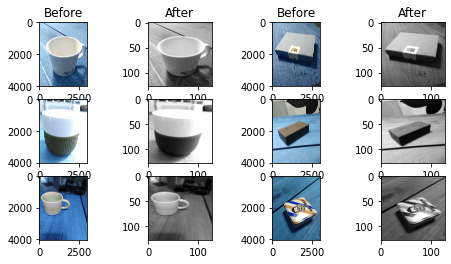

In [3]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(8, 4))
# Cups
axs[0, 0].set_title("Before")
axs[0, 1].set_title("After")
axs[0, 0].imshow(cups[0])
axs[0, 1].imshow(small_cups[0], cmap="gray")
axs[1, 0].imshow(cups[120])
axs[1, 1].imshow(small_cups[120], cmap="gray")
axs[2, 0].imshow(cups[-1])
axs[2, 1].imshow(small_cups[-1], cmap="gray");
# Boxes
axs[0, 2].set_title("Before")
axs[0, 3].set_title("After")
axs[0, 2].imshow(boxes[0])
axs[0, 3].imshow(small_boxes[0], cmap="gray")
axs[1, 2].imshow(boxes[120])
axs[1, 3].imshow(small_boxes[120], cmap="gray")
axs[2, 2].imshow(boxes[-1])
axs[2, 3].imshow(small_boxes[-1], cmap="gray");

### Data augmentation
- Rotation
- Shifting
- Flipping
- Noise & Blurr

In [4]:
from helpers import *
%run helpers.py

In [97]:
def augment_images(images,
                    operations=["flip", "blur", "rotate"], # Accumelate augmentations
                    acc = [False, False, False], # Accumelation or not
                    vertical=False, horizontal=True, # Flip
                    angle=15, # Rotate
                    sigma=0.5, octaves=3 # Blur
                    ):
    augmented = []
    for i, op in enumerate(operations):
        
        if op=="flip":
            if acc[i]:
                augmented += flipper(imgs=images+augmented, vertical=vertical, horizontal=horizontal)
            else:
                augmented += flipper(imgs=images, vertical=vertical, horizontal=horizontal)
        elif op=="blur":
            if acc[i]:
                augmented += scaleSpaced(imgs=images+augmented, sigma=sigma, n=octaves)
            else:
                augmented += scaleSpaced(imgs=images, sigma=sigma, n=octaves)
        elif op=="rotate":
            if acc[i]:
                augmented += rotate_imgs(imgs=images+augmented, angle=angle)
                augmented += rotate_imgs(imgs=images+augmented, angle=-angle)
            else:
                augmented += rotate_imgs(imgs=images, angle=angle)
                augmented += rotate_imgs(imgs=images, angle=-angle)
        else:
            raise Exception("Invalid operation", operations)
            
    return augmented



***Using "acuumelate" we can go from 2->62 images!***

**Have not yet implemented** shifting, interpolation or grey noise.

Now lets run it for all images and store the results.

In [100]:
augmented_cups = augment_images(small_cups,
                    operations=["flip", "rotate", "blur",], # Accumelate augmentations
                    acc = [False, False, True], # Accumelation or not
                    vertical=False, horizontal=True, # Flip
                    angle=15, # Rotate
                    sigma=0.5, octaves=3 # Blur
                    )

# Also add original images ? 
#augmented_cups += deepcopy(small_cups)
print(len(small_cups),"-->", len(augmented_cups))

198 --> 2970


In [101]:
augmented_boxes = augment_images(small_boxes,
                    operations=["flip", "rotate", "blur",], # Accumelate augmentations
                    acc = [False, False, True], # Accumelation or not
                    vertical=False, horizontal=True, # Flip
                    angle=15, # Rotate
                    sigma=0.5, octaves=3 # Blur
                    )
# Also add original images ? 
# augmented_boxes+=deepcopy(small_boxes)                          
print(len(small_boxes),"-->", len(augmented_boxes))

256 --> 3840


### Store images

In [102]:
store_images(augmented_boxes, path='henriks_images/augment_box/')
store_images(augmented_cups, path='henriks_images/augment_cup/')

(3840, 128, 128)
(2970, 128, 128)


### Test the data with simple ML scheme

In [59]:
# Flatten
flat_agumented_box = flatten(augmented_boxes)
flat_agumented_cup = flatten(augmented_cups)

# Get a scaler/normalizer over all the data
(scaled_cups, scaled_boxes), raw_scaler = normalize(all_data=[flat_agumented_box, flat_agumented_cup], scaler_type='minmax')

# Reshape (if needed) - row vectors needed for ANN!
ann_cups = reshape(scaled_cups, vec_type="row")
ann_boxes = reshape(scaled_boxes, vec_type="row")

# Add to a dataframe for tidyness
flat_ann_df = from_numpy_to_pd(data=[ann_cups, ann_boxes], labels=[0, 1])

#from sklearn.model_selection import train_test_split
#train, test = train_test_split(flat_ann_df, test_size=0.2)

In [61]:
# Model training on raw flat data
flat_model = tf.keras.Sequential()
flat_model.add(layers.Dense(np.asarray(flat_ann_df["data"]).shape[0], activation=tf.nn.relu))
flat_model.add(layers.Dense(32, activation=tf.nn.relu))
flat_model.add(layers.Dense(32, activation=tf.nn.relu))
flat_model.add(layers.Dense(2, activation=tf.nn.softmax)) 

flat_model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.metrics.sparse_categorical_crossentropy,
              metrics=['accuracy']
              )

In [91]:
flat_history = flat_model.fit(
                    x=np.stack(flat_ann_df['data'], 0),
                    y=np.float32(flat_ann_df['label']),
                    epochs=15, verbose=1,
                    validation_split = 0.3,
                    batch_size=100,
                    #callbacks=[PrintDot()]
                    )

Epoch 1/15
102/102 [==============================] - 88s 859ms/step - loss: 0.6565 - accuracy: 0.8102 - val_loss: 2.0564 - val_accuracy: 0.0321
Epoch 2/15
102/102 [==============================] - 86s 842ms/step - loss: 0.2877 - accuracy: 0.8939 - val_loss: 1.3989 - val_accuracy: 0.4393
Epoch 3/15
102/102 [==============================] - 92s 899ms/step - loss: 0.2020 - accuracy: 0.9280 - val_loss: 1.1757 - val_accuracy: 0.5504
Epoch 4/15
102/102 [==============================] - 91s 896ms/step - loss: 0.1871 - accuracy: 0.9321 - val_loss: 0.9489 - val_accuracy: 0.6258
Epoch 5/15
102/102 [==============================] - 93s 908ms/step - loss: 0.1653 - accuracy: 0.9411 - val_loss: 2.3969 - val_accuracy: 0.3159
Epoch 6/15
102/102 [==============================] - 97s 957ms/step - loss: 0.1446 - accuracy: 0.9491 - val_loss: 0.8790 - val_accuracy: 0.6596
Epoch 7/15
102/102 [==============================] - 102s 997ms/step - loss: 0.1292 - accuracy: 0.9546 - val_loss: 1.9135 - val_a

,loss,accuracy,val_loss,val_accuracy,epoch
14,0.075672,0.974137,2.062875,0.486121,14


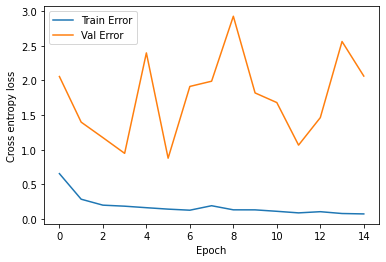

In [92]:
show_final_score(flat_history)